The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Análise de Sentimentos e o *Dataset*
:label:`sec_sentiment`


A classificação de texto é uma tarefa comum no processamento de linguagem natural, que transforma uma sequência de texto de comprimento indefinido em uma categoria de texto. É semelhante à classificação de imagem, o aplicativo usado com mais frequência neste livro, por exemplo, :numref:`sec_naive_bayes`. A única diferença é que, em vez de uma imagem, o exemplo da classificação de texto é uma frase de texto.

Esta seção se concentrará no carregamento de dados para uma das subquestões neste campo: usar a classificação de sentimento do texto para analisar as emoções do autor do texto. Esse problema também é chamado de análise de sentimento e tem uma ampla gama de aplicações. Por exemplo, podemos analisar resenhas de usuários de produtos para obter estatísticas de satisfação do usuário ou analisar os sentimentos do usuário sobre as condições de mercado e usá-las para prever tendências futuras.


In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

## O Dataset de Análise de Sentimento

Usamos o *dataset* [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)  de Stanford para análise de sentimento. Este conjunto de dados é dividido em dois conjuntos de dados para fins de treinamento e teste, cada um contendo 25.000 resenhas de filmes baixadas da IMDb. Em cada conjunto de dados, o número de comentários rotulados como "positivos" e "negativos" é igual.

###  Lendo o *Dataset*

Primeiro, baixamos esse *dataset* para o caminho "../data" e o extraímos para "../data/aclImdb".


In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Em seguida, leia os conjuntos de dados de treinamento e teste. Cada exemplo é uma revisão e seu rótulo correspondente: 1 indica "positivo" e 0 indica "negativo".


In [3]:
#@save
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Normally the best way to annoy me in a film is to include so
label: 1 review: The Bible teaches us that the love of money is the root of a
label: 1 review: Being someone who lists Night of the Living Dead at number t


### Tokenização e Vocabulário

Usamos uma palavra como token e, em seguida, criamos um dicionário com base no conjunto de dados de treinamento.


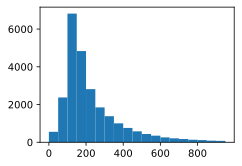

In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

d2l.set_figsize()
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

### Preenchimento com o mesmo comprimento

Como as resenhas têm durações diferentes, não podem ser combinadas diretamente em minibatches. Aqui, fixamos o comprimento de cada comentário em 500, truncando ou adicionando índices "&lt;unk&gt;".


In [5]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


### Criando o Iterador de Dados

Agora, criaremos um iterador de dados. Cada iteração retornará um minibatch de dados.


In [6]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## Juntando Tudo

Por último, salvaremos uma função `load_data_imdb` em` d2l`, que retorna o vocabulário e iteradores de dados.


In [7]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## Resumo

* A classificação de texto pode classificar uma sequência de texto em uma categoria.
* Para classificar um sentimento de texto, carregamos um conjunto de dados IMDb e tokenizar suas palavras. Em seguida, preenchemos a sequência de texto para revisões curtas e criamos um iterador de dados.

## Exercícios

1. Descubra um conjunto de dados de linguagem natural diferente (como [revisões da Amazon](https://snap.stanford.edu/data/web-Amazon.html)) e crie uma função data_loader semelhante como `load_data_imdb`.


[Discussões](https://discuss.d2l.ai/t/1387)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE5NzA3NTE2ODIsMTE5ODA3NjYwNiwtMT
gzNDI1MjAyNiw2OTA2NzM4MThdfQ==
-->
